In [1]:
import wandb
wandb.login()  # Opens a browser once to authenticate


wandb: Currently logged in as: analiju (analiju-paris) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset, ConcatDataset
from torchvision import datasets, transforms
from torchvision.models import resnet50
from itertools import product
import numpy as np
import random
import copy
import os, ssl, zipfile, urllib
import sklearn
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

LOCAL_OR_COLAB = "LOCAL"
SEED           = 42
NUM_EPOCHS     = 3
DEVICE         = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TRAIN_FRAC = 0.7
VAL_FRAC   = 0.15
TEST_FRAC  = 0.15

# hyperparameter grid
# BATCH_SIZES = [64, 128, 256]
BATCH_SIZES = [32]  # Using a single batch size for simplicity
LRS = [1e-4]

if LOCAL_OR_COLAB == "LOCAL":
    DATA_DIR = "/users/c/carvalhj/datasets/EuroSAT_RGB/"
else:
    data_root = "/content/EuroSAT_RGB"
    zip_path  = "/content/EuroSAT.zip"
    if not os.path.exists(data_root):
        ssl._create_default_https_context = ssl._create_unverified_context
        urllib.request.urlretrieve(
            "https://madm.dfki.de/files/sentinel/EuroSAT.zip", zip_path
        )
        with zipfile.ZipFile(zip_path, "r") as z:
            z.extractall("/content")
        os.rename("/content/2750", data_root)
    DATA_DIR = data_root

NUM_WORKERS = 4 

In [ ]:

def compute_mean_std(dataset, batch_size):
    loader = DataLoader(dataset, batch_size, shuffle=False, num_workers=2)
    mean = 0.0
    std = 0.0
    n_samples = 0

    for data, _ in loader:
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)  # (B, C, H*W)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        n_samples += batch_samples

    mean /= n_samples
    std /= n_samples
    return mean.tolist(), std.tolist()

def get_data_loaders(data_dir, batch_size):

    base_tf = transforms.ToTensor()
    ds_all = datasets.ImageFolder(root=data_dir, transform=base_tf)
    labels = np.array(ds_all.targets)   # numpy array of shape (N,)
    num_classes = len(ds_all.classes)
    total_count = len(ds_all)
    print(f"Total samples in folder: {total_count}, classes: {ds_all.classes}")

    train_idx, val_idx, test_idx = get_split_indexes(labels, total_count)

    train_subset_for_stats = Subset(ds_all, train_idx)
    mean, std = compute_mean_std(train_subset_for_stats, batch_size)
    print(f"Computed mean: {mean}")
    print(f"Computed std:  {std}")

    tf_final = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    #  full ImageFolder but now with normalization baked in
    ds_all_norm = datasets.ImageFolder(root=data_dir, transform=tf_final)

    train_ds = Subset(ds_all_norm, train_idx)
    val_ds   = Subset(ds_all_norm, val_idx)
    test_ds  = Subset(ds_all_norm, test_idx)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=NUM_WORKERS, generator=torch.Generator().manual_seed(SEED))
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS, generator=torch.Generator().manual_seed(SEED))
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS, generator=torch.Generator().manual_seed(SEED))

    # calculate class proportions
    prop_train = get_proportion(num_classes, train_ds)
    prop_val   = get_proportion(num_classes, val_ds)
    prop_test  = get_proportion(num_classes, test_ds)
    plot_proportions(ds_all, num_classes, prop_train, prop_val, prop_test)
    print(f"Train/Val/Test splits: {len(train_ds)}/{len(val_ds)}/{len(test_ds)}")

    return train_loader, val_loader, test_loader, num_classes

def get_proportion(num_classes, dataset):
    return np.bincount(np.array(dataset.dataset.targets)[dataset.indices], minlength=num_classes) / len(dataset)

def get_split_indexes(labels, total_count):
    n_train = int(np.floor(TRAIN_FRAC * total_count))
    n_temp = total_count - n_train   # this is val + test

    sss1 = StratifiedShuffleSplit(
        n_splits=1,
        train_size=n_train,
        test_size=n_temp,
        random_state=SEED
    )
    # Train and temp(val+test) indices
    train_idx, temp_idx = next(sss1.split(np.zeros(total_count), labels))

    n_val = int(np.floor(VAL_FRAC * total_count))
    n_test = total_count - n_train - n_val
    assert n_temp == n_val + n_test, "Fractions must sum to 1."

    labels_temp = labels[temp_idx]

    sss2 = StratifiedShuffleSplit(
        n_splits=1,
        train_size=n_val,
        test_size=n_test,
        random_state=SEED
    )
    val_idx_in_temp, test_idx_in_temp = next(sss2.split(np.zeros(len(temp_idx)), labels_temp))

    val_idx = temp_idx[val_idx_in_temp]
    test_idx = temp_idx[test_idx_in_temp]

    assert len(train_idx) == n_train
    assert len(val_idx) == n_val
    assert len(test_idx) == n_test

    print(f"Stratified split sizes: train={len(train_idx)}, val={len(val_idx)}, test={len(test_idx)}")
    return train_idx,val_idx,test_idx

def plot_proportions(ds_all, num_classes, prop_train, prop_val, prop_test, acc_per_class=None):
    print(f"Class proportions (%):")
    print(f"  Train: {100 * prop_train}")
    print(f"   Val:  {100 * prop_val}")
    print(f"  Test:  {100 * prop_test}")
    x = np.arange(num_classes)
    width = 0.25
    plt.figure(figsize=(10, 5))
    plt.bar(x - width, 100 * prop_train, width, label='Train')
    plt.bar(x,         100 * prop_val,   width, label='Val')
    plt.bar(x + width, 100 * prop_test,  width, label='Test')
    plt.xlabel('Class Index')
    plt.ylabel('Proportion (%)')
    plt.title('Stratified Class Proportions in Train/Val/Test')
    plt.xticks(x, ds_all.classes, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False


def build_model(n_cls, pretrained=False):
    m = resnet50(weights=None if not pretrained else "DEFAULT")
    m.fc = nn.Linear(m.fc.in_features, n_cls)
    return m.to(DEVICE)

def train_one_epoch(model, loader, opt, crit, sched=None):
    model.train()
    tot_loss, corr, tot = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad()
        logits = model(xb)

        loss   = crit(logits, yb)
        loss.backward()
        opt.step()
        if sched: sched.step()
        tot_loss += loss.item()
        preds    = logits.argmax(dim=1)
        corr    += (preds==yb).sum().item()
        tot     += yb.size(0)
        avg_loss = tot_loss / len(loader)

    avg_loss = tot_loss / len(loader)
    acc = 100.0 * corr / tot
    return avg_loss, acc

def evaluate(model, loader, num_classes):
    model.eval()
    # overall counters
    total_correct = 0
    total_samples = 0

    # per-class counters (torch tensors on CPU)
    correct_per_class = torch.zeros(num_classes, dtype=torch.int64)
    total_per_class   = torch.zeros(num_classes, dtype=torch.int64)

    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            preds  = logits.argmax(dim=1)

            # overall
            total_correct += (preds == yb).sum().item()
            total_samples += yb.size(0)

            # per-class (vectorized)
            for c in range(num_classes):
                # mask of samples in this batch whose true label == c
                class_mask = (yb == c)
                if class_mask.sum().item() == 0:
                    continue

                # increment total count for class c
                total_per_class[c] += class_mask.sum().item()

                # increment correct count for class c
                correct_per_class[c] += ((preds == yb) & class_mask).sum().item()

    # compute percentages
    overall_acc = 100.0 * total_correct / total_samples

    acc_per_class = {}
    for c in range(num_classes):
        if total_per_class[c].item() > 0:
            acc = 100.0 * correct_per_class[c].item() / total_per_class[c].item()
        else:
            # if a class never appears in the loader, define accuracy as 0 (or skip)
            acc = 0.0
        acc_per_class[c] = acc

    return overall_acc, acc_per_class


def hyperparam_search(pretrained=True):
    best_val = -1.0
    best_cfg = None
    best_model = None

    for bs, lr in [(b, l) for b in BATCH_SIZES for l in LRS]:
        print(f"\n>>> Testing BS={bs}, LR={lr:.1e}")
        set_seed(SEED)
        tr_dl, val_dl, te_dl, n_cls = get_data_loaders(DATA_DIR, bs)
        model = build_model(n_cls, pretrained=pretrained)

        opt   = optim.Adam(model.parameters(), lr=lr)
        # sched = optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.9)
        sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=NUM_EPOCHS * len(tr_dl))
        crit  = nn.CrossEntropyLoss()

        # Start a W&B run
        wandb_run = wandb.init(
            project="eurosat-supervised-scratch-grid-search",
            name=f"BS{bs}_LR{lr:.0e}",
            config={
                "batch_size": bs,
                "learning_rate": lr,
                "epochs": NUM_EPOCHS,
                "pretrained": pretrained,
            }
        )

        for ep in range(NUM_EPOCHS):
            tr_loss, tr_acc = train_one_epoch(model, tr_dl, opt, crit, sched)
            # Compute validation loss & accuracy in one pass
            model.eval()
            val_loss, corr, tot = 0.0, 0, 0
            with torch.no_grad():
                for xb, yb in val_dl:
                    xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                    logits = model(xb)
                    loss = crit(logits, yb)
                    val_loss += loss.item()
                    preds = logits.argmax(dim=1)
                    corr += (preds == yb).sum().item()
                    tot  += yb.size(0)
            val_loss /= len(val_dl)
            val_acc = 100.0 * corr / tot

            print(f"  Ep{ep+1}/{NUM_EPOCHS}: train_acc={tr_acc:.1f}%  val_acc={val_acc:.1f}%  val_loss={val_loss:.4f}")

            # Log metrics to W&B
            wandb.log({
                "epoch":       ep + 1,
                "train_loss":  tr_loss,
                "train_acc":   tr_acc,
                "val_loss":    val_loss,
                "val_acc":     val_acc
            })

        wandb_run.finish()

        # Only use val_acc to pick best
        if val_acc > best_val:
            best_val   = val_acc
            best_cfg   = (bs, lr)
            best_model = copy.deepcopy(model)

    print(f"\n>>> Best config: BS={best_cfg[0]}, LR={best_cfg[1]:.1e}, val_acc={best_val:.1f}%")
    
    return best_cfg, best_model





>>> Testing BS=32, LR=1.0e-04
Total samples in folder: 27000, classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Stratified split sizes: train=18900, val=4050, test=4050
Computed mean: [0.34389418363571167, 0.3799557387828827, 0.4075564742088318]
Computed std:  [0.09309431165456772, 0.06472521275281906, 0.05418707802891731]
Class proportions (%):
  Train: [11.11111111 11.11111111 11.11111111  9.25925926  9.25925926  7.40740741
  9.25925926 11.11111111  9.25925926 11.11111111]
   Val:  [11.11111111 11.11111111 11.11111111  9.25925926  9.25925926  7.40740741
  9.25925926 11.11111111  9.25925926 11.11111111]
  Test:  [11.11111111 11.11111111 11.11111111  9.25925926  9.25925926  7.40740741
  9.25925926 11.11111111  9.25925926 11.11111111]


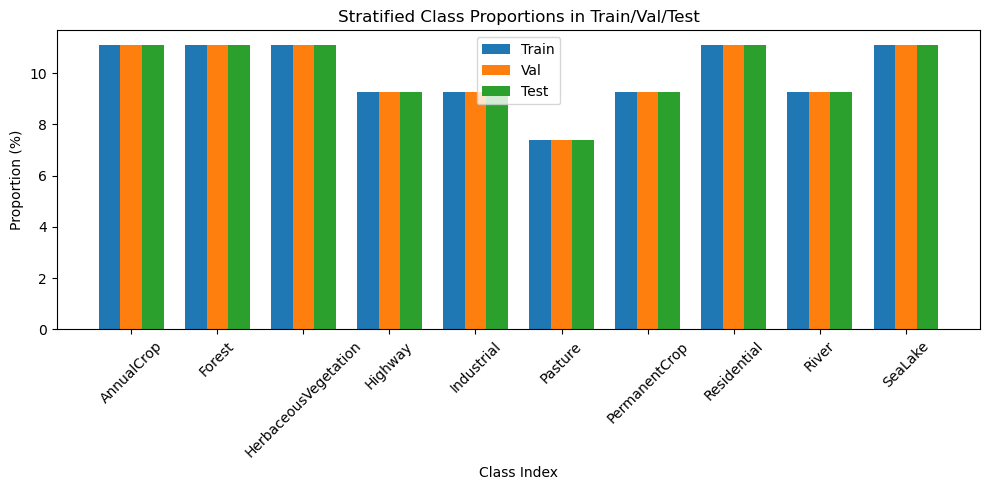

Train/Val/Test splits: 18900/4050/4050


  Ep1/3: train_acc=53.3%  val_acc=66.8%  val_loss=0.9051
  Ep2/3: train_acc=69.5%  val_acc=74.4%  val_loss=0.7043
  Ep3/3: train_acc=75.6%  val_acc=76.9%  val_loss=0.6321


epoch,▁▅█
train_acc,▁▆█
train_loss,█▃▁
val_acc,▁▆█
val_loss,█▃▁
epoch,3
train_acc,75.57143
train_loss,0.68242
val_acc,76.91358
val_loss,0.63211



>>> Best config: BS=32, LR=1.0e-04, val_acc=76.9%
Total samples in folder: 27000, classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Stratified split sizes: train=18900, val=4050, test=4050
Computed mean: [0.34389418363571167, 0.3799557387828827, 0.4075564742088318]
Computed std:  [0.09309431165456772, 0.06472521275281906, 0.05418707802891731]
Class proportions (%):
  Train: [11.11111111 11.11111111 11.11111111  9.25925926  9.25925926  7.40740741
  9.25925926 11.11111111  9.25925926 11.11111111]
   Val:  [11.11111111 11.11111111 11.11111111  9.25925926  9.25925926  7.40740741
  9.25925926 11.11111111  9.25925926 11.11111111]
  Test:  [11.11111111 11.11111111 11.11111111  9.25925926  9.25925926  7.40740741
  9.25925926 11.11111111  9.25925926 11.11111111]


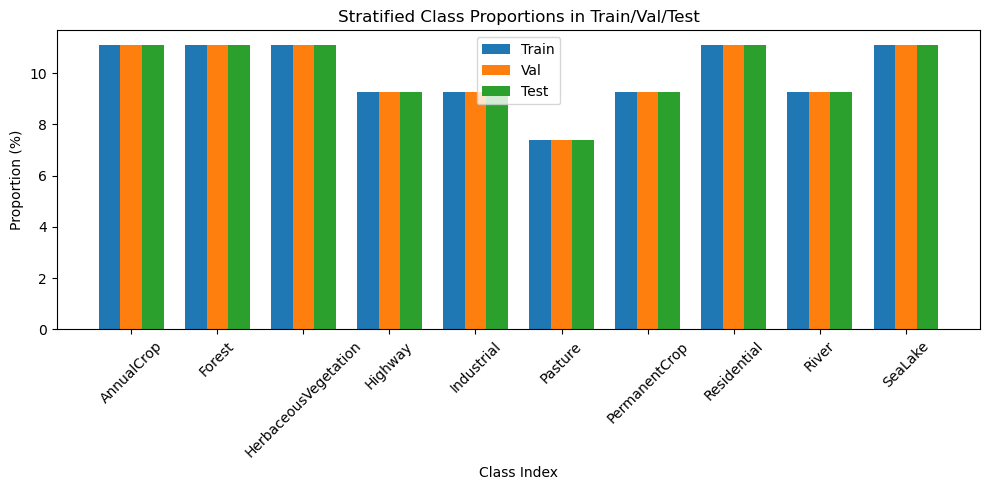

Train/Val/Test splits: 18900/4050/4050


In [5]:
# Main

best_cfg, best_model = hyperparam_search(pretrained=False)

bs, lr = best_cfg
tr_dl, val_dl, te_dl, n_cls = get_data_loaders(DATA_DIR, bs)


In [6]:


print("\n>>> Retraining final model on TRAIN+VAL combined with best hyperparameters")
combined_dataset = ConcatDataset([tr_dl.dataset, val_dl.dataset])
combined_dl = DataLoader(combined_dataset, batch_size=bs, shuffle=True, num_workers=4)

set_seed(SEED)
final_model = build_model(n_cls, pretrained=False)
opt_final = optim.Adam(final_model.parameters(), lr=lr)
# sched_final = optim.lr_scheduler.StepLR(opt_final, step_size=10, gamma=0.9)
# CosineAnnealingLR over all training *steps* (NUM_EPOCHS × len(train_loader))
sched_final = optim.lr_scheduler.CosineAnnealingLR(opt_final, T_max=NUM_EPOCHS * len(tr_dl))

crit_final  = nn.CrossEntropyLoss()

for ep in range(NUM_EPOCHS):
    loss, acc = train_one_epoch(final_model, combined_dl, opt_final, crit_final, sched=sched_final)
    
    print(f"  Final Retrain Ep{ep+1}/{NUM_EPOCHS}: train_acc={acc:.1f}%")
# save the final model
final_model_path = "models/eurosat_supervised_final_model_bs{}_lr{:.0e}.pth".format(bs, lr)
torch.save(final_model.state_dict(), final_model_path)
print(f"Final model saved to {final_model_path}")



>>> Retraining final model on TRAIN+VAL combined with best hyperparameters
  Final Retrain Ep1/3: train_acc=55.7%
  Final Retrain Ep2/3: train_acc=71.0%
  Final Retrain Ep3/3: train_acc=75.5%
Final model saved to models/eurosat_supervised_final_model_bs32_lr1e-04.pth


In [36]:
def plot_class_acc_prop():
    classes = te_dl.dataset.dataset.classes
    x = np.arange(len(classes))

    acc   = acc_vals
    prop  = class_proportions_test * 100

    fig, ax1 = plt.subplots(figsize=(12,6))
    bars = ax1.bar(x, acc, color='C0', alpha=0.7)
    ax1.set_ylabel('Accuracy (%)', color='C0')
    ax1.set_ylim(0, 100)
    ax1.tick_params(axis='y', labelcolor='C0')

    for bar in bars:
        h = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, h + 1, f'{h:.1f}%', ha='center', va='bottom', color='C0')

    ax2 = ax1.twinx()
    line = ax2.plot(x, prop, color='C1', marker='o', linewidth=2)
    ax2.set_ylabel('Test Proportion (%)', color='C1')
    ax2.set_ylim(0, max(prop)*1.2)
    ax2.tick_params(axis='y', labelcolor='C1')

    for xi, yi in zip(x, prop):
        ax2.text(xi, yi + max(prop)*0.02, f'{yi:.1f}%', ha='center', va='bottom', color='C1')

    ax1.set_xticks(x)
    ax1.set_xticklabels(classes, rotation=45, ha='right')
    plt.title('Per-class Accuracy vs. Test Proportion')
    plt.tight_layout()
    plt.show()




>>> Final Test Accuracy:
  Overall:              77.4%
  Weighted class acc.:  77.4%

Class                    Acc   Train+Val     Test
-------------------------------------------------
AnnualCrop              79.6%         11%       11%
Forest                  91.8%         11%       11%
HerbaceousVegetation    68.4%         11%       11%
Highway                 31.5%          9%        9%
Industrial              91.7%          9%        9%
Pasture                 89.0%          7%        7%
PermanentCrop           61.3%          9%        9%
Residential             94.4%         11%       11%
River                   64.3%          9%        9%
SeaLake                 95.3%         11%       11%


final_test_acc,▁
weighted_class_acc,▁
final_test_acc,77.35802
weighted_class_acc,77.35802


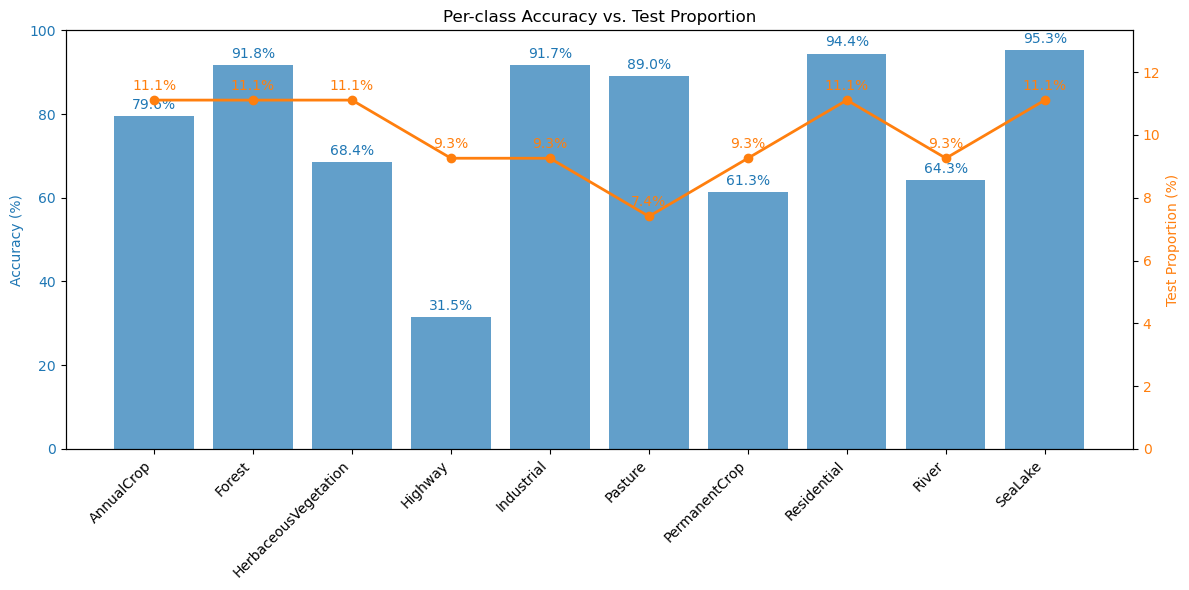

In [37]:


final_test_acc, acc_per_class = evaluate(final_model, te_dl, n_cls)

test_targets = np.array(te_dl.dataset.dataset.targets)[te_dl.dataset.indices]
class_proportions_test = np.bincount(test_targets, minlength=n_cls) / len(test_targets)

combined_targets = np.concatenate([
    np.array(sub.dataset.targets)[sub.indices]
    for sub in combined_dataset.datasets
])
class_proportion_train_val = np.bincount(combined_targets, minlength=n_cls) / len(combined_targets)

acc_vals = np.array([acc_per_class[c] for c in range(n_cls)])
weighted_class_acc = (acc_vals * class_proportions_test).sum()

print("\n>>> Final Test Accuracy:")
print(f"  Overall:             {final_test_acc:5.1f}%")
print(f"  Weighted class acc.: {weighted_class_acc:5.1f}%\n")

hdr = f"{'Class':20s}  {'Acc':>6s}   {'Train+Val':>9s}   {'Test':>6s}"
print(hdr)
print("-" * len(hdr))

for c, name in enumerate(te_dl.dataset.dataset.classes):
    acc  = acc_vals[c]
    p_tr = class_proportion_train_val[c] * 100
    p_te = class_proportions_test[c]    * 100
    print(f"{name:20s}  {acc:6.1f}%   {p_tr:8.0f}%   {p_te:6.0f}%")

wandb.init(
    project="eurosat-supervised-scratch-final",
    name=f"BS{bs}_LR{lr:.0e}_final",
    config={
        "batch_size":     bs,
        "learning_rate":  lr,
        "epochs":         NUM_EPOCHS,
        "pretrained":     False,
        "final_retrain":  True
    }
)
wandb.log({
    "final_test_acc":      final_test_acc,
    "weighted_class_acc":  weighted_class_acc,
    "per_class_acc":       acc_vals
})
wandb.finish()

plot_class_acc_prop()